In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

plt.rcParams["figure.figsize"] = (10, 6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.options.display.float_format = '{:.3f}'.format

In [133]:
df = pd.read_csv("Iris.csv")
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100,3.500,1.400,0.200,Iris-setosa
1,4.900,3.000,1.400,0.200,Iris-setosa
2,4.700,3.200,1.300,0.200,Iris-setosa
3,4.600,3.100,1.500,0.200,Iris-setosa
4,5.000,3.600,1.400,0.200,Iris-setosa


## 1. Exploratory Data Analysis

In [134]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  150 non-null    float64
 1   sepal_width_cm   150 non-null    float64
 2   petal_length_cm  150 non-null    float64
 3   petal_width_cm   150 non-null    float64
 4   species          150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [136]:
df.shape

(150, 5)

In [137]:
df.describe()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
count,150.000,150.000,150.000,150.000
mean,5.843,3.054,3.759,1.199
std,0.828,0.434,1.764,0.763
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500


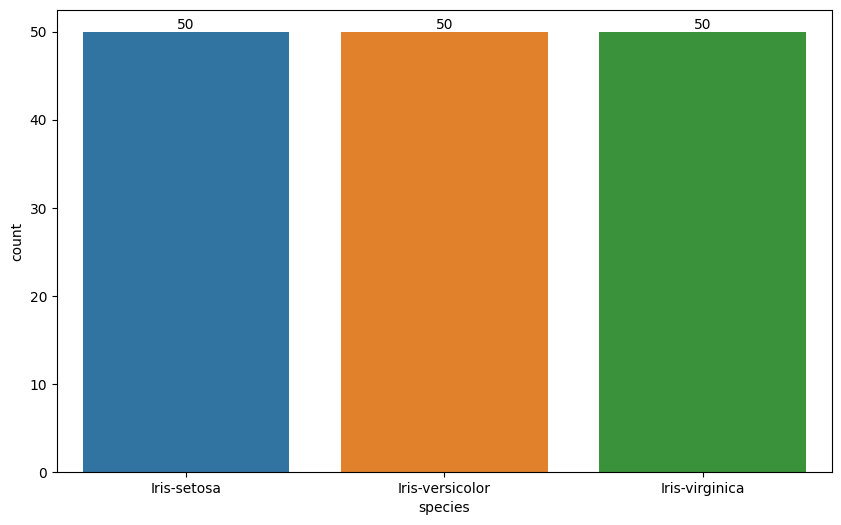

In [138]:
ax = sns.countplot(df["species"])
for i in ax.containers:
    ax.bar_label(i)
# Balanced Data

<AxesSubplot:>

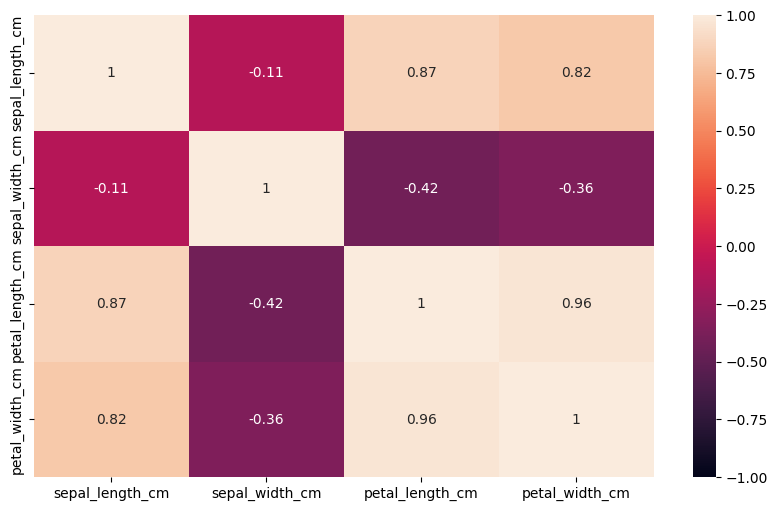

In [139]:
sns.heatmap(df.corr(), annot=True, vmin=-1)

In [140]:
df.groupby("species").mean()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
species,,,,
Iris-setosa,5.006,3.418,1.464,0.244
Iris-versicolor,5.936,2.770,4.260,1.326
Iris-virginica,6.588,2.974,5.552,2.026


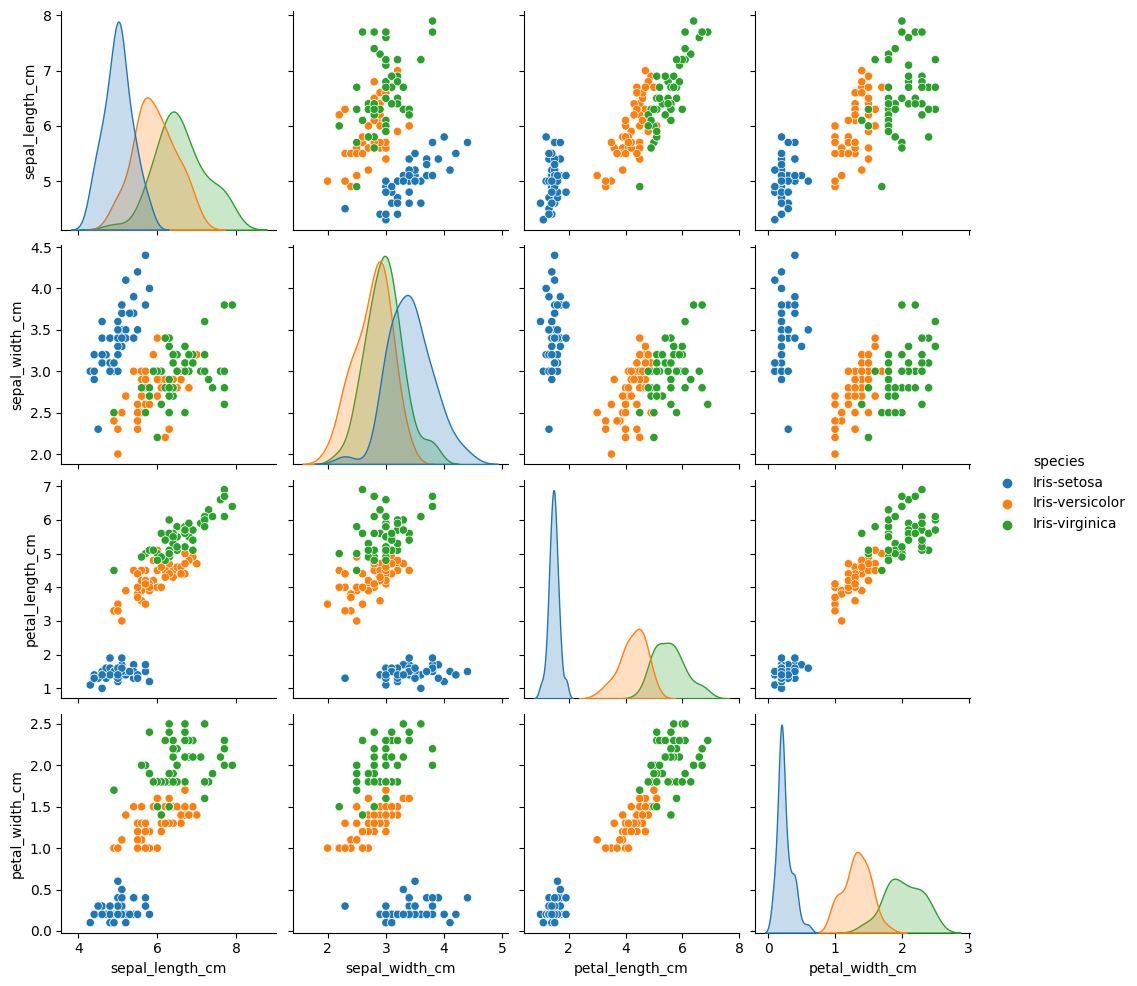

In [141]:
sns.pairplot(df, hue="species");

In [142]:
fig = px.scatter_3d(df, x = "sepal_length_cm", y ="sepal_width_cm", z = "petal_length_cm", color="species")
fig.show()

## 2. Logistic Regression
### 2.1 Train | Test Split and Scaling

In [143]:
X = df.drop(columns="species")
y = df["species"]

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [146]:
scaler = StandardScaler()

In [147]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2 Modelling and Model Performance (with default parameters)

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

In [149]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [150]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [151]:
eval_metric(log_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Train_Set
[[40  0  0]
 [ 0 38  3]
 [ 0  1 38]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        40
Iris-versicolor       0.97      0.93      0.95        41
 Iris-virginica       0.93      0.97      0.95        39

       accuracy                           0.97       120
      macro avg       0.97      0.97      0.97       120
   weighted avg       0.97      0.97      0.97       120



### 2.3 Cross Validation (with default parameters)

In [152]:
from sklearn.model_selection import cross_validate

In [153]:
model = LogisticRegression(random_state=42)

scores = cross_validate(model, X_train_scaled, y_train, 
                        scoring = ['accuracy', 'precision_weighted','recall_weighted','f1_weighted'], 
                        cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy             0.933
test_precision_weighted   0.942
test_recall_weighted      0.933
test_f1_weighted          0.932
dtype: float64

### 2.4 GridSearch

In [154]:
log_model = LogisticRegression(random_state=42)

In [155]:
penalty = ["l1", "l2", "elasticnet"]
C = np.logspace(-1, 5, 20)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

param_grid = {"penalty" : penalty, "C" : C, "solver" : solver}

In [156]:
grid_model = GridSearchCV(log_model, param_grid=param_grid, cv=10, n_jobs=-1)

In [157]:
%%time
grid_model.fit(X_train_scaled, y_train)

CPU times: total: 906 ms
Wall time: 4.24 s


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [158]:
grid_model.best_params_

{'C': 7.847599703514611, 'penalty': 'l2', 'solver': 'newton-cg'}

In [159]:
eval_metric(grid_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Train_Set
[[40  0  0]
 [ 0 39  2]
 [ 0  1 38]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        40
Iris-versicolor       0.97      0.95      0.96        41
 Iris-virginica       0.95      0.97      0.96        39

       accuracy                           0.97       120
      macro avg       0.97      0.98      0.97       120
   weighted avg       0.98      0.97      0.98       120



## 3. Final Model and Deployment

In [160]:
import pickle

In [161]:
scaler = StandardScaler().fit(X)
pickle.dump(scaler, open("scaler_iris.pickle", "wb"))

In [162]:
X_scaled = scaler.transform(X)

In [163]:
grid_model.best_params_

{'C': 7.847599703514611, 'penalty': 'l2', 'solver': 'newton-cg'}

In [164]:
final_model = LogisticRegression(C=7.847, penalty="l2", solver="newton-cg").fit(X_scaled, y)

In [165]:
pickle.dump(final_model, open("final_model_iris.pickle", "wb"))

## 4. Using The Model

In [166]:
X.describe()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
count,150.000,150.000,150.000,150.000
mean,5.843,3.054,3.759,1.199
std,0.828,0.434,1.764,0.763
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500


In [167]:
my_dict = {"sepal_length_cm": [4.5, 5.8, 7.5, 7.0],
           "sepal_width_cm": [2.2, 3, 4.2, 4.0],
           "petal_length_cm": [1.3, 4.3, 6.5, 6.0],
           "petal_width_cm": [0.2, 1.3, 2.3, 2.3]
          }

In [168]:
sample = pd.DataFrame(my_dict)
sample

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
0,4.500,2.200,1.300,0.200
1,5.800,3.000,4.300,1.300
2,7.500,4.200,6.500,2.300
3,7.000,4.000,6.000,2.300


In [169]:
scaler_iris = pickle.load(open("scaler_iris.pickle", "rb"))

In [170]:
sample_scaled = scaler_iris.transform(sample)
sample_scaled

array([[-1.62768839, -1.97618132, -1.39813811, -1.31297673],
       [-0.05250608, -0.1249576 ,  0.30783301,  0.13322594],
       [ 2.00734772,  2.65187798,  1.5588785 ,  1.44795564],
       [ 1.40150837,  2.18907205,  1.27454998,  1.44795564]])

In [171]:
final_model = pickle.load(open("final_model_iris.pickle", "rb"))

In [172]:
predictions = final_model.predict(sample_scaled)
predictions_proba = final_model.predict_proba(sample_scaled)

In [173]:
predictions

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica'], dtype=object)

In [174]:
sample["pred"] = predictions
sample["pred_proba_setosa"] = predictions_proba[:,0]
sample["pred_proba_versicolor"] = predictions_proba[:,1]
sample["pred_proba_virginica"] = predictions_proba[:,2]
sample

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,pred,pred_proba_setosa,pred_proba_versicolor,pred_proba_virginica
0,4.500,2.200,1.300,0.200,Iris-setosa,0.866,0.134,0.000
1,5.800,3.000,4.300,1.300,Iris-versicolor,0.008,0.984,0.008
2,7.500,4.200,6.500,2.300,Iris-virginica,0.000,0.003,0.997
3,7.000,4.000,6.000,2.300,Iris-virginica,0.000,0.006,0.994
